# EUAir Transport Dataset Experiments

In [1]:
%run codes/utils

In [2]:
import glob
import re
# Progress bar.
from tqdm import tqdm

# Grab all subdatasets names into a list of strings.
all_files = glob.glob("datasets/EUAir/LOOCV_subdatasets_EUAir/*")
all_files.sort(key=lambda f: int(re.sub('\D', '', f)))

nodes = len(all_files)
avg_rank = np.zeros(nodes, dtype=float)
# LOOCV_ranking_distribution = []

for subdata in tqdm(all_files):
    sub_network, _, sub_size = loadEUAirTransport(subdata)
    sub_x, sub_z = stage1(sub_network, sub_size, 1, 1, 1)

    # If the following error has been raised, it means the last node was removed, so the program
    # detected the size of the network (n - 1). Therefore, because the last node does not exist in the
    # current subnetwork, so we need to add a zero as its weight. Note the "last" node could be removed
    # sometimes in a very low possibility, so we used a "while" loop instead of an "if" statement.
    # ValueError: operands could not be broadcast together with shapes (n,) (n - 1,) (n,)
    while len(sub_x) != nodes:
        sub_x = np.append(sub_x, 0.0)

    sorted_indices = np.argsort(-sub_x)
    V_sub_x = np.empty_like(sorted_indices)
    V_sub_x[sorted_indices] = np.arange(len(sub_x))

    avg_rank += V_sub_x
    # The following statement would generate a 450 * 450 table (list * np.ndarray) to store the result
    # from each iteration in LOOCV.
    # LOOCV_ranking_distribution.append(sub_x)

avg_rank /= nodes
# flatten_ranking = np.concatenate(LOOCV_ranking_distribution).ravel()

100%|█████████████████████████████████████████| 450/450 [02:51<00:00,  2.62it/s]


In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
from scipy import stats

In [4]:
origin_network, _, origin_size = loadEUAirTransport("datasets/EUAir/EUAir_Transportation_multiplex.csv")

o_x, o_z = stage1(origin_network, origin_size, 1, 1, 1)
sorted_indices = np.argsort(-o_x)
V_o_x = np.empty_like(sorted_indices)
V_o_x[sorted_indices] = np.arange(len(-o_x))

difference = V_o_x - avg_rank
abs_difference = abs(difference)
percentage_diff = difference / len(difference)

## Compare the Difference between one-time Results and LOOCV Results

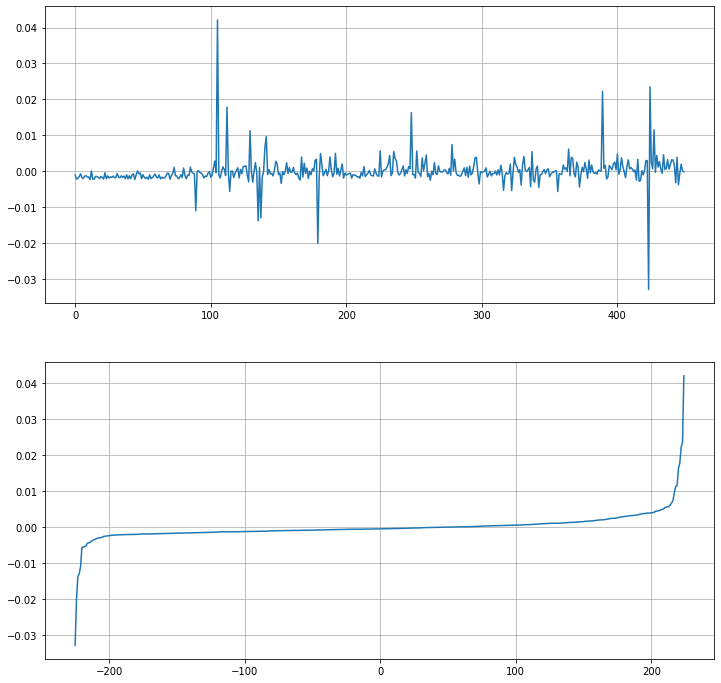

In [5]:
fig, (us, s) = plt.subplots(2, 1, figsize=(12, 12))

sort = sorted(percentage_diff)
x_axis = np.arange(0.0, 450.0, 1.0)
x_axis_sort = np.arange(-225.0, 225.0, 1.0)

us.plot(x_axis, percentage_diff)
us.grid(True)
s.plot(x_axis_sort, sort)
s.grid(True)

plt.show()

In [6]:
count = 0
for val in percentage_diff:
    if abs(val) <= 0.01:
        count += 1
print("There are %.2f%% nodes have a less than 1.0%% difference with LOOCV result." %(count / len(percentage_diff) * 100))

There are 97.33% nodes have a less than 1.0% difference with LOOCV result.


In [7]:
betw_centra = s1_betweenness_centrality(origin_network, origin_size)
clos_centra = s1_closeness_centrality(origin_network, origin_size)
degr_centra = s1_degree_centrality(origin_network, origin_size)
eige_centra = s1_eigenvector_centrality(origin_network, origin_size)
rho_betw, p_betw = stats.spearmanr(o_x, betw_centra)
rho_clos, p_clos = stats.spearmanr(o_x, clos_centra)
rho_degr, p_degr = stats.spearmanr(o_x, degr_centra)
rho_eige, p_eige = stats.spearmanr(o_x, eige_centra)

## Spearman's Rank Correlation Coefficient to Demonstrate the Robustness

In [8]:
# Spearman's rank correlation coefficient between our
# results and networkx **betweenness** centralities.
rho_betw, p_betw

(0.8640157764513703, 1.3223502568148643e-135)

In [9]:
# Spearman's rank correlation coefficient between our
# results and networkx **closeness** centralities.
rho_clos, p_clos

(0.8673213271066078, 7.908259029280741e-138)

In [10]:
# Spearman's rank correlation coefficient between our
# results and networkx **degree** centralities.
rho_degr, p_degr

(0.9964455410340898, 0.0)

In [11]:
# Spearman's rank correlation coefficient between our
# results and networkx **eigenvector** centralities.
rho_eige, p_eige

(0.9225156885128195, 2.4080108581048014e-187)